In [6]:
"""
    This notebook is used to generate the figures for the following section:
    "Preliminaries"
"""

'\n    This notebook is used to generate the figures for the following section:\n    "Preliminaries"\n'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from da import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from da import DICs

In [8]:
from utils import gamma_uniform_mean_std_matching
g_bar_range_leak = [0.0, 0.02]
g_bar_leak_gamma = gamma_uniform_mean_std_matching(*g_bar_range_leak)
print(g_bar_leak_gamma)

(3.0, 0.0033333333333333335)


In [9]:
# Sample a lot of da and plot the distribution of V_th
def get_individual(f=1/4, normalize=False):
    g_bar_range_Na = [0, 60]
    g_bar_range_Kd = [0, 20]
    g_bar_range_CaL = [0, 0.1]
    g_bar_range_CaN = [0, 0.12]
    g_bar_range_ERG = [0, 0.25]
    g_bar_range_leak = [0, 0.02]

    g_bar_range_Na = [g_bar_range_Na[0] + (g_bar_range_Na[1] - g_bar_range_Na[0])*f, g_bar_range_Na[1] - (g_bar_range_Na[1] - g_bar_range_Na[0])*f]
    g_bar_range_Kd = [g_bar_range_Kd[0] + (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f, g_bar_range_Kd[1] - (g_bar_range_Kd[1] - g_bar_range_Kd[0])*f]
    g_bar_range_CaL = [g_bar_range_CaL[0] + (g_bar_range_CaL[1] - g_bar_range_CaL[0])*f, g_bar_range_CaL[1] - (g_bar_range_CaL[1] - g_bar_range_CaL[0])*f]
    g_bar_range_CaN = [g_bar_range_CaN[0] + (g_bar_range_CaN[1] - g_bar_range_CaN[0])*f, g_bar_range_CaN[1] - (g_bar_range_CaN[1] - g_bar_range_CaN[0])*f]
    g_bar_range_ERG = [g_bar_range_ERG[0] + (g_bar_range_ERG[1] - g_bar_range_ERG[0])*f, g_bar_range_ERG[1] - (g_bar_range_ERG[1] - g_bar_range_ERG[0])*f]
    g_bar_range_leak = [g_bar_range_leak[0] + (g_bar_range_leak[1] - g_bar_range_leak[0])*f, g_bar_range_leak[1] - (g_bar_range_leak[1] - g_bar_range_leak[0])*f]
    g_bar_leak_gamma = gamma_uniform_mean_std_matching(*g_bar_range_leak)

    g_leak = np.random.gamma(g_bar_leak_gamma[0], g_bar_leak_gamma[1]) 
    g_Na = np.random.uniform(*g_bar_range_Na)
    g_Kd = np.random.uniform(*g_bar_range_Kd)
    g_CaL = np.random.uniform(*g_bar_range_CaL)
    g_CaN = np.random.uniform(*g_bar_range_CaN)
    g_ERG = np.random.uniform(*g_bar_range_ERG)
    
    if normalize:
        f = g_leak/0.01
        g_Na *= f
        g_Kd *= f
        g_CaL *= f
        g_CaN *= f
        g_ERG *= f
        g_NMDA = g_ERG * 0.12
        

    return np.array([g_Na, g_Kd, g_CaL, g_CaN, g_ERG, g_NMDA, g_leak])

N = 2000
V_ths = np.zeros(N)
dics_th = np.zeros((2,N))
population = np.zeros((N, 7))
from da import find_V_th_DICs
from tqdm import tqdm

V = np.linspace(-80, 0, 100)
for i in tqdm(range(N)):
    individual = get_individual(f=0, normalize=True)
    population[i] = individual
    v = find_V_th_DICs(V, *individual, **get_default_parameters(), max_iter=100)
    V_ths[i] = v[0].item()
    g_th = v[1]
    dics_th[0,i] = g_th[1]
    dics_th[1,i] = g_th[2]

# extract the DICs at -51 mV
V = -55.5
#V = -63.0
dics = DICs(V, *(population.T), **get_default_parameters())
dics = np.array(dics).squeeze()
print(dics.shape)

g_s = dics[1]
g_u = dics[2]

residual_s = g_s - dics_th[0]
residual_u = g_u - dics_th[1]

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_4943/1556317426.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dics_th[0,i] = g_th[1]
/tmp/ipykernel_4943/1556317426.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dics_th[1,i] = g_th[2]
100%|██████████| 2000/2000 [00:48<00:00, 41.00it/s]

(4, 2000)


-62.94256602957953
-64.7204404888731


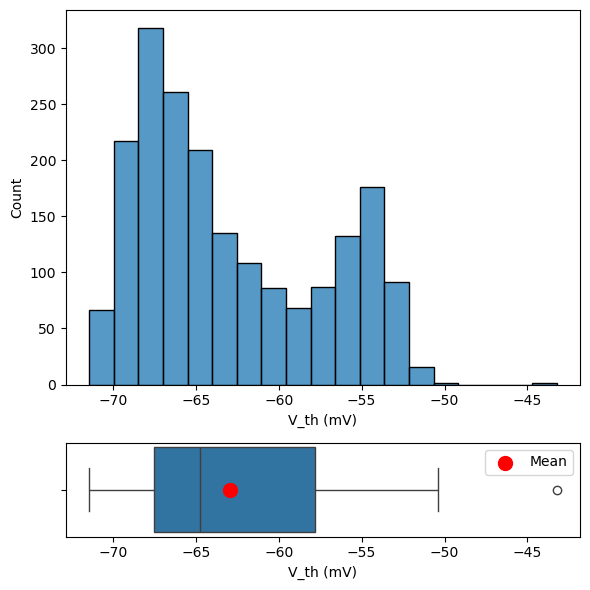

In [10]:
# clean the data (remove nan)
V_ths_local = V_ths[~np.isnan(V_ths)]
# remove highly positive values
#V_ths_local = V_ths_local[V_ths_local < -30]

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={"height_ratios": [4, 1]})

# Plot the histogram
sns.histplot(V_ths_local, ax=ax_hist, bins='auto')
ax_hist.set_xlabel('V_th (mV)')
ax_hist.set_ylabel('Count')

# Plot the boxplot
sns.boxplot(x=V_ths_local, ax=ax_box, orient='h')
ax_box.set_xlabel('V_th (mV)')

# scatter the mean
print(np.mean(V_ths_local))
print(np.median(V_ths_local))
ax_box.scatter(np.mean(V_ths_local), 0, color='red', s=100, label='Mean', marker='o', zorder=5) 
ax_box.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Save to svg
plt.savefig('figures/da_V_th_combined.svg')

# Show the plot
plt.show()

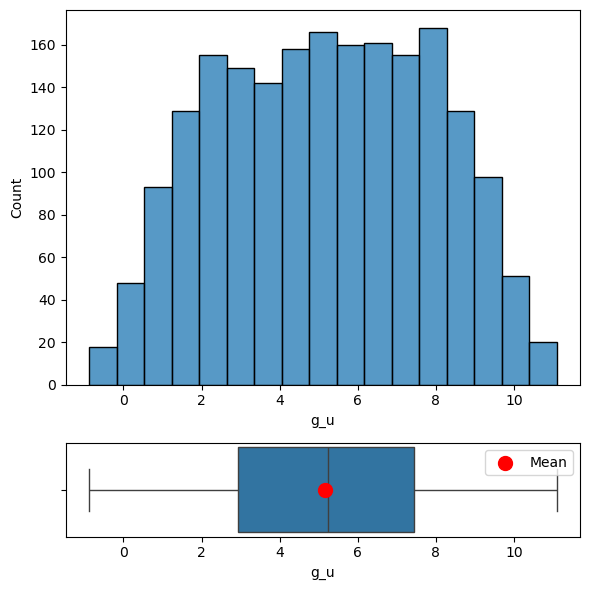

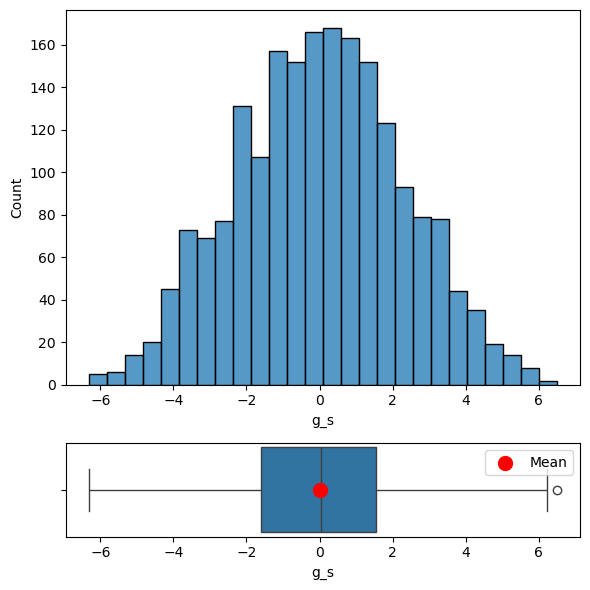

In [11]:
# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={"height_ratios": [4, 1]})
# Plot the histogram
sns.histplot(g_u, ax=ax_hist, bins='auto')
ax_hist.set_xlabel('g_u')
ax_hist.set_ylabel('Count')

# Plot the boxplot
sns.boxplot(x=g_u, ax=ax_box, orient='h')
ax_box.set_xlabel('g_u')

# Scatter the mean
ax_box.scatter(np.mean(g_u), 0, color='red', s=100, label='Mean', marker='o', zorder=5)
ax_box.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Save to svg
#plt.savefig('figures/da_g_u_combined.svg')

# Show the plot
plt.show()

# for g_s

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={"height_ratios": [4, 1]})
# Plot the histogram
sns.histplot(g_s, ax=ax_hist, bins='auto')
ax_hist.set_xlabel('g_s')
ax_hist.set_ylabel('Count')

# Plot the boxplot
sns.boxplot(x=g_s, ax=ax_box, orient='h')
ax_box.set_xlabel('g_s')

# Scatter the mean
ax_box.scatter(np.mean(g_s), 0, color='red', s=100, label='Mean', marker='o', zorder=5)
ax_box.legend(loc='upper right')

# Adjust layout
plt.tight_layout()

# Save to svg
#plt.savefig('figures/da_g_s_combined.svg')

# Show the plot
plt.show()

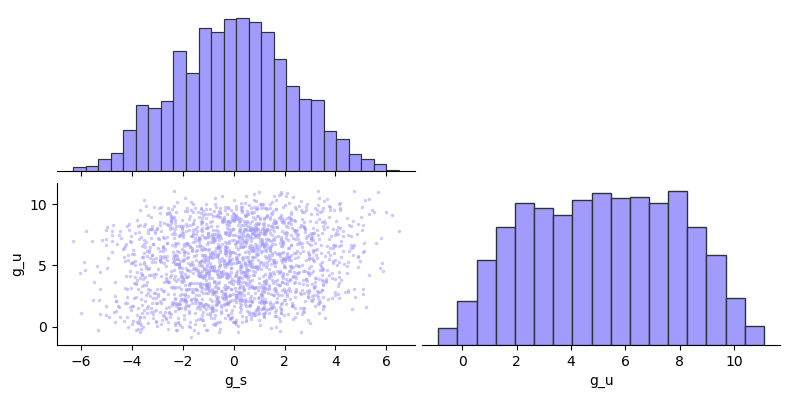

g_s min: -6.303842902339972
g_s max: 6.490194556511257
g_u min: -0.8744583416997919
g_u max: 11.092570097458212
g_s mean: -0.00033043091491236965
g_s std: 2.2790639944640465
g_u mean: 5.173903224668273
g_u std: 2.7229898263543024
g_s median: 0.040449233569697984
g_u median: 5.242320099988103


In [12]:
#pairplot of g_s and g_u
co = "#a29bfe"
edge_co = "#2d3436"
df = pd.DataFrame({'g_s': g_s, 'g_u': g_u})
sns.pairplot(df, plot_kws={'alpha': 0.5, 'edgecolor': None, 's': 5, 'color': co}, corner=True, diag_kws={'color': co, 'alpha': 1, 'edgecolor': edge_co}, height=2, aspect=2)
plt.savefig('figures/da_g_s_g_u_pairplot.svg')
plt.show()

# print min and max values
print('g_s min:', np.min(g_s))
print('g_s max:', np.max(g_s))
print('g_u min:', np.min(g_u))
print('g_u max:', np.max(g_u))
# print mean and std
print('g_s mean:', np.mean(g_s))
print('g_s std:', np.std(g_s))
print('g_u mean:', np.mean(g_u))
print('g_u std:', np.std(g_u))
#print med
print('g_s median:', np.median(g_s))
print('g_u median:', np.median(g_u))

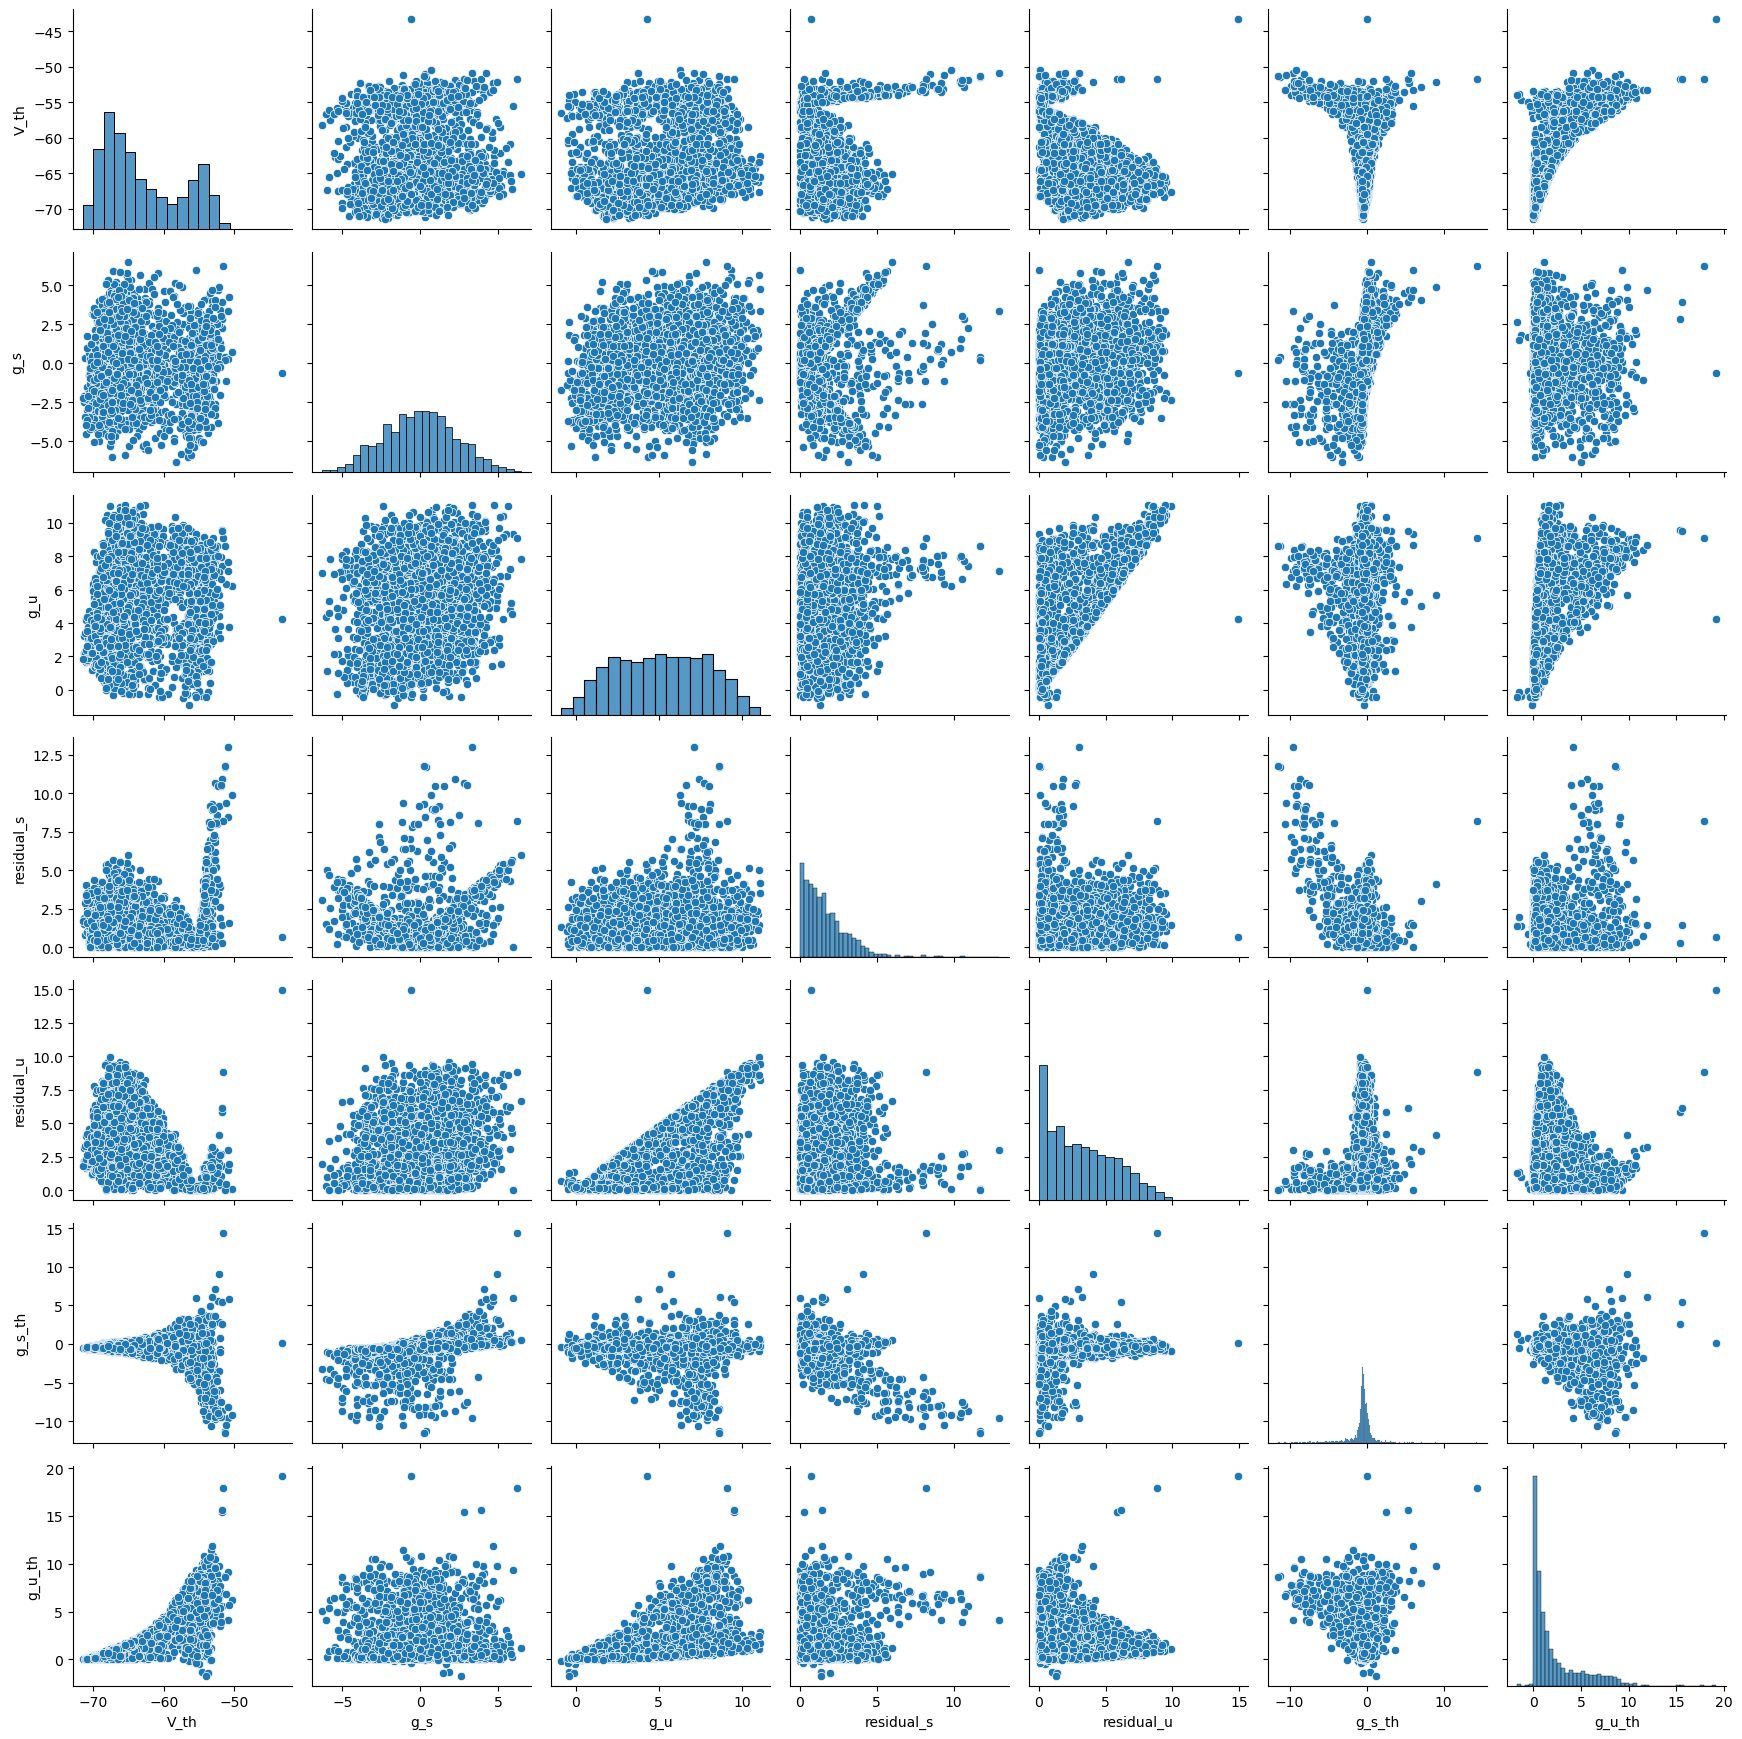

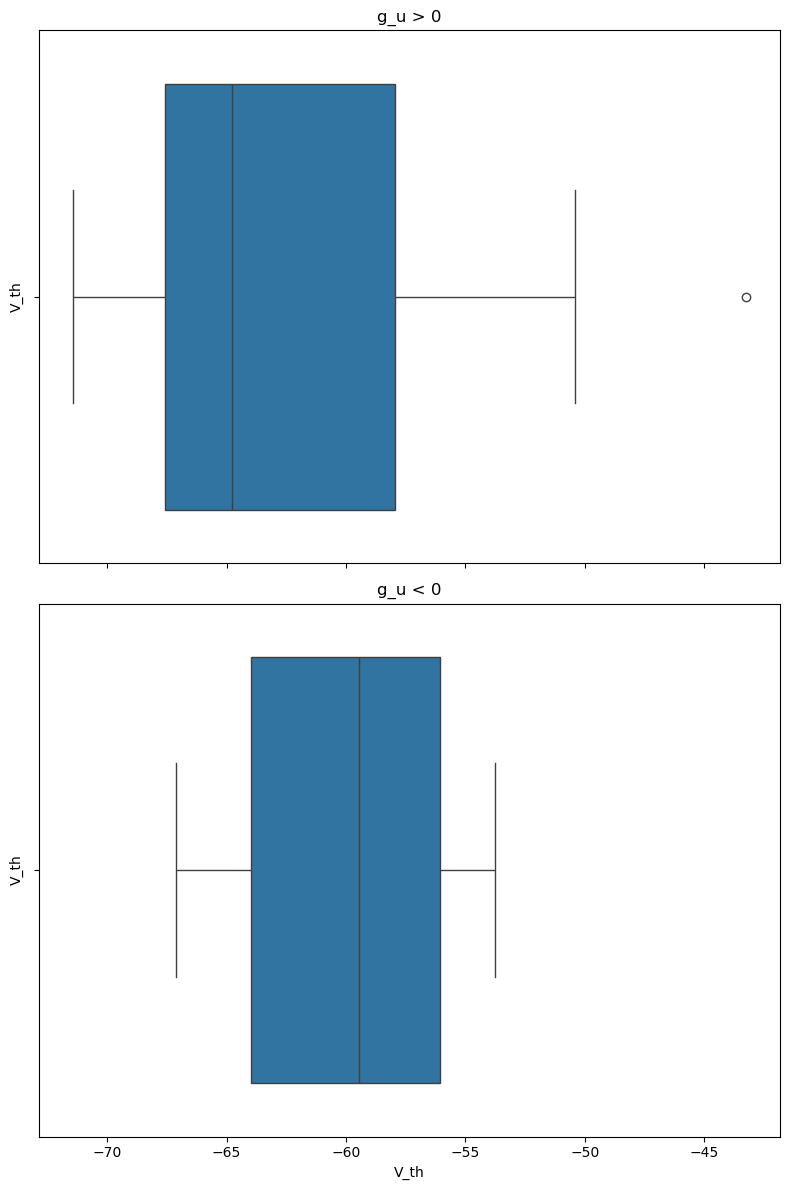

Mean and Median of V_th for g_u > 0:
Mean: -62.9812093112244
Median: -64.77507003630049

Mean and Median of V_th for g_u < 0:
Mean: -59.66796794584774
Median: -59.45137409248738


In [13]:
# do a pairplot of V_th, g_s, g_u, residual_s, residual_u, dics th
df = pd.DataFrame({'V_th': V_ths, 'g_s': g_s, 'g_u': g_u, 'residual_s': residual_s, 'residual_u': residual_u, 'g_s_th': dics_th[0], 'g_u_th': dics_th[1]})

# refilter the data according to the V_th
df = df[df['V_th'] < -40]

#residual in absolute value
df['residual_s'] = np.abs(df['residual_s'])
df['residual_u'] = np.abs(df['residual_u'])

sns.pairplot(df)
plt.tight_layout()
# save to svg
plt.savefig('figures/da_V_th_g_s_g_u_residual_pairplot.svg')
plt.show()

# do two boxplot of vth : one for g_u < 0 and one for g_u > 0
positive_g_u = df[df['g_u'] > 0]
negative_g_u = df[df['g_u'] < 0]
fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

sns.boxplot(x='V_th', data=positive_g_u, ax=axes[0])
axes[0].set_title('g_u > 0')
axes[0].set_ylabel('V_th')

sns.boxplot(x='V_th', data=negative_g_u, ax=axes[1])
axes[1].set_title('g_u < 0')
axes[1].set_ylabel('V_th')
axes[1].set_xlabel('V_th')

plt.tight_layout()
plt.show()

# print mean and median of V_th for g_u > 0 and g_u < 0
print("Mean and Median of V_th for g_u > 0:")
print("Mean:", positive_g_u['V_th'].mean())
print("Median:", positive_g_u['V_th'].median())

print("\nMean and Median of V_th for g_u < 0:")
print("Mean:", negative_g_u['V_th'].mean())
print("Median:", negative_g_u['V_th'].median())


In [14]:
if False:
    # exlore the dataset : find population with negative g_u
    idx = np.where(g_u < 0)[0]

    # among those, find the ones with negative g_s
    idx1 = idx[np.where(g_s[idx] < 0)[0]]

    # among those, find the ones with positive g_s
    idx2 = idx[np.where(g_s[idx] > 0)[0]]

    print(idx1)
    print(idx2)

    # sample n of each
    n = 10
    idx1 = np.random.choice(idx1, n)
    idx2 = np.random.choice(idx2, n)

    population1 = population[idx1]
    population2 = population[idx2]

    from da import simulate_individual_t_eval, get_default_u0, get_default_parameters
    import warnings
    from utils import simulate_population_t_eval_multiprocessing

    # Wrapper to simulate the population using multiprocessing
    def simulate_population(population, U0 = get_default_u0(), T_EVAL = np.arange(3000, 4000, 0.5), PARAMS=get_default_parameters(), MAX_WORKERS=16):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            return np.asarray(simulate_population_t_eval_multiprocessing(simulate_individual_t_eval, population, U0, T_EVAL, PARAMS, MAX_WORKERS,verbose=True))[:, 1, :]

    t_eval = np.arange(3000, 4000, 0.05)
    sol_idx1 = simulate_population(population1, T_EVAL=t_eval)
    sol_idx2 = simulate_population(population2, T_EVAL=t_eval)

    # Plot the results
    fig, ax = plt.subplots(n, 1, figsize=(6, 6), sharex=True)
    for i in range(n):
        ax[i].plot(t_eval, sol_idx1[i, :], label='g_u < 0 and g_s < 0')
        ax[i].set_ylabel('V (mV)')
        ax[i].legend()
    plt.xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(n, 1, figsize=(6, 6), sharex=True)
    for i in range(n):
        ax[i].plot(t_eval, sol_idx2[i, :], label='g_u < 0 and g_s > 0', color='orange')
        ax[i].set_ylabel('V (mV)')
        ax[i].legend()
    plt.xlabel('Time (ms)')
    plt.tight_layout()
    plt.show()

    # for each of them, we generate a neuromod population of sime m
    m = 5

    from da import generate_neuromodulated_population

    for i in range(n):
        neuromod_population = generate_neuromodulated_population(m, -51., g_s_target=g_s[idx1[i]], g_u_target=g_u[idx1[i]])
        sol_neuromod = simulate_population(neuromod_population, T_EVAL=t_eval)

        # plot the original in red
        fig, ax = plt.subplots(1, 1, figsize=(6, 6/m))
        ax.plot(t_eval, sol_idx1[i, :], label=f'Original, g_s = {g_s[idx1[i]]:.2f}, g_u = {g_u[idx1[i]]:.2f}', color='red')
        ax.set_ylabel('V (mV)')
        ax.legend()
        plt.xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()

        # plot the neuromodulated in blue
        fig, ax = plt.subplots(m, 1, figsize=(6, 6))
        for j in range(m):
            ax[j].plot(t_eval, sol_neuromod[j, :], label='Neuromodulated')
            ax[j].set_ylabel('V (mV)')
            ax[j].legend()
        plt.xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()

    # for each of them, we generate a neuromod population of sime m

    for i in range(n):
        neuromod_population = generate_neuromodulated_population(m, -51., g_s_target=g_s[idx2[i]], g_u_target=g_u[idx2[i]])
        sol_neuromod = simulate_population(neuromod_population, T_EVAL=t_eval)

        # plot the original in red
        fig, ax = plt.subplots(1, 1, figsize=(6, 6/m))
        ax.plot(t_eval, sol_idx2[i, :], label=f'Original, g_s = {g_s[idx2[i]]:.2f}, g_u = {g_u[idx2[i]]:.2f}', color='red')
        ax.set_ylabel('V (mV)')
        ax.legend()
        plt.xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()

        # plot the neuromodulated in blue
        fig, ax = plt.subplots(m, 1, figsize=(6, 6))
        for j in range(m):
            ax[j].plot(t_eval, sol_neuromod[j, :], label='Neuromodulated')
            ax[j].set_ylabel('V (mV)')
            ax[j].legend()
        plt.xlabel('Time (ms)')
        plt.tight_layout()
        plt.show()

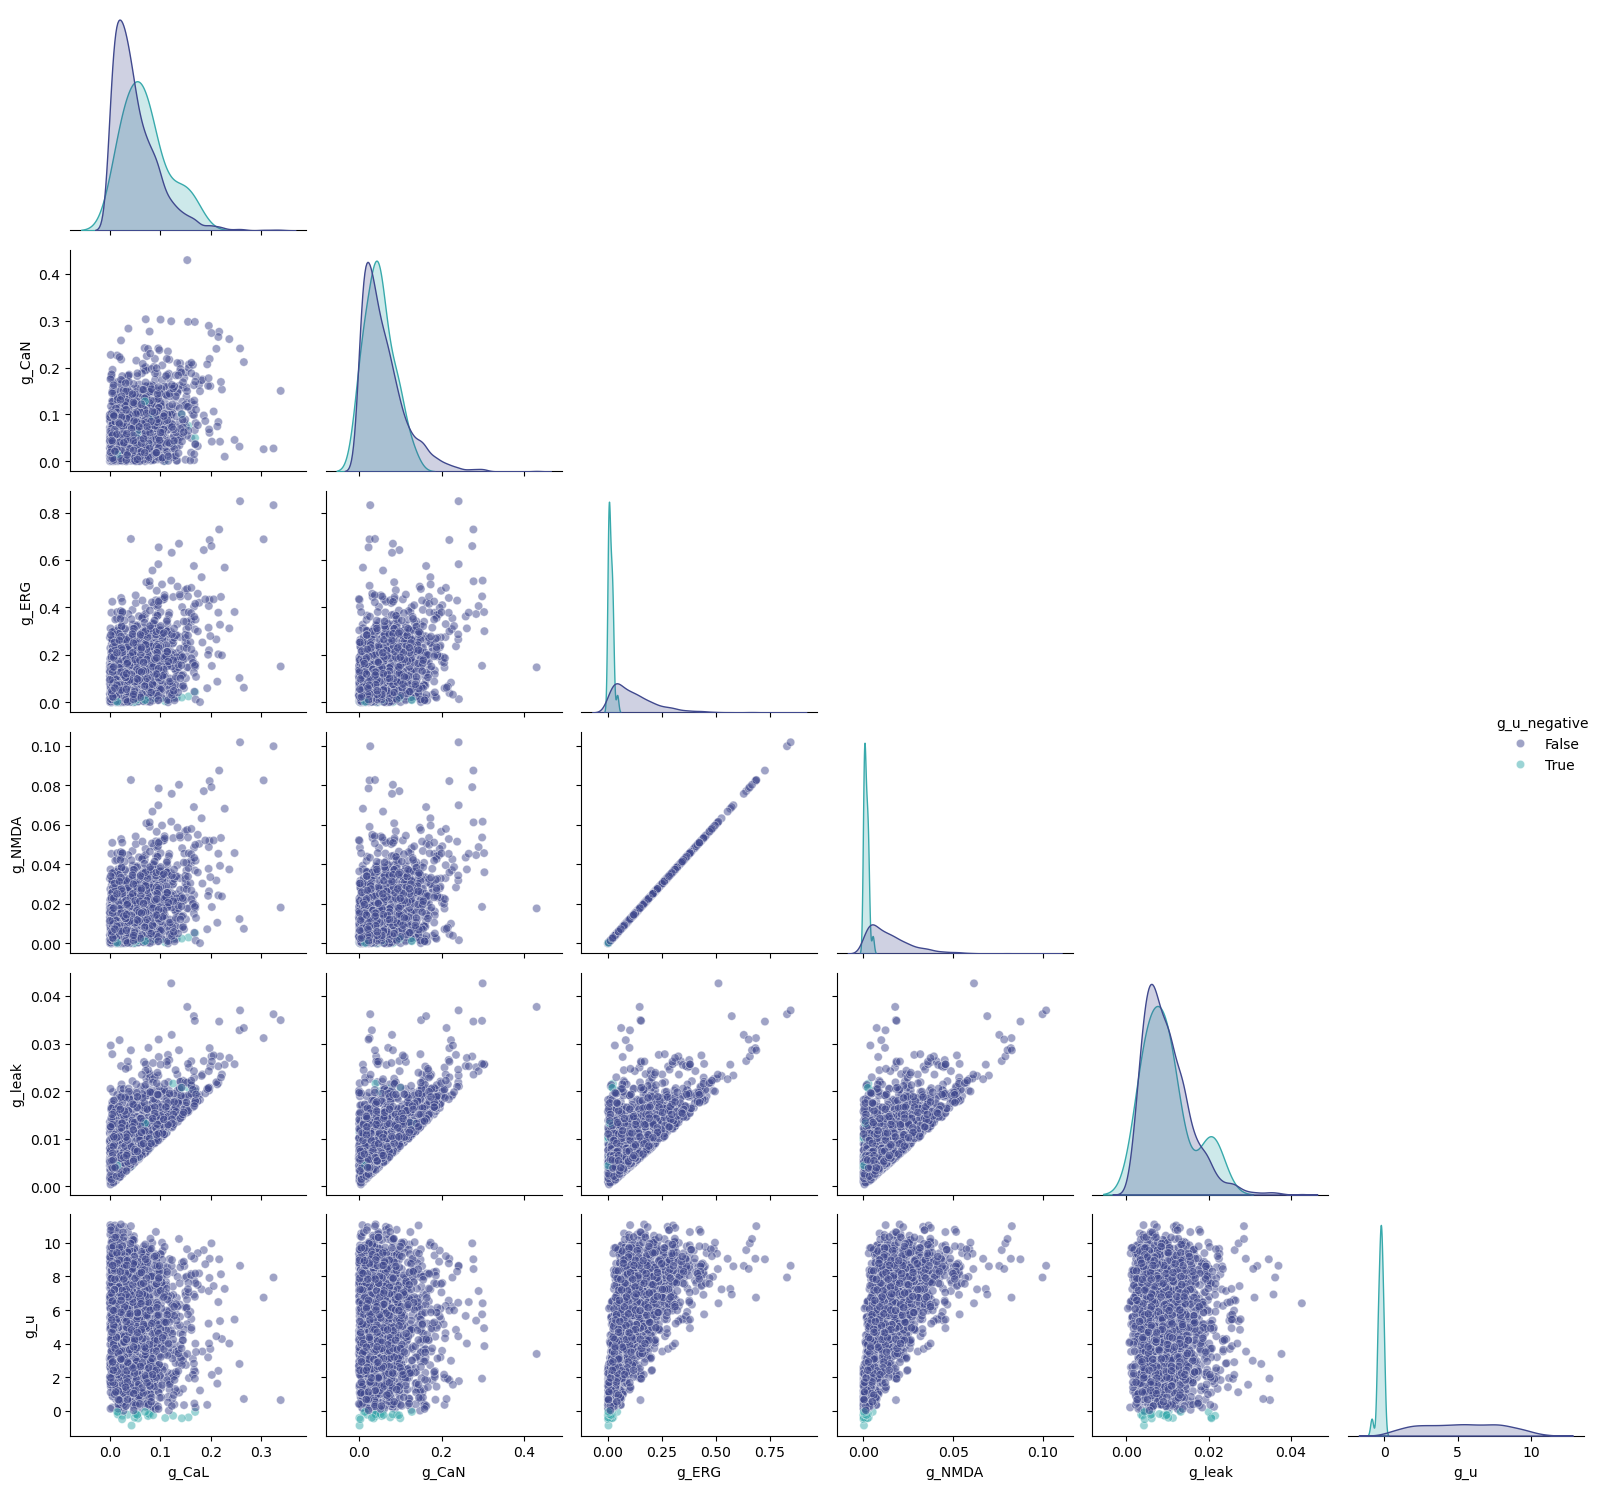

In [15]:
# I want to make a pairplot of g_s and g_u and population (g_Na, g_Kd, ...)

# Create a dataframe
df = pd.DataFrame(population, columns=['g_Na', 'g_Kd', 'g_CaL', 'g_CaN', 'g_ERG', 'g_NMDA', 'g_leak'])
df['g_u'] = g_u

# remove g_Na and g_Kd 
df = df.drop(columns=['g_Na', 'g_Kd'])

# add a label wheter or not g_u is negative
df['g_u_negative'] = df['g_u'] < 0

# Create the pairplot with color coding with the g_u_negative
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.5}, hue='g_u_negative', diag_kws={'fill': True, 'common_norm': False}, palette='mako', corner=True)
plt.tight_layout()
plt.show()

[-100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.  -60.  -55.  -50.  -45.
  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.    0.]


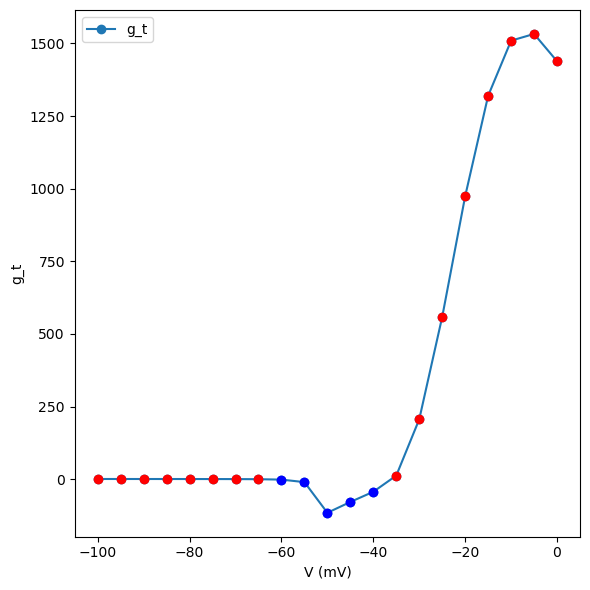

In [16]:
# sample one individual:
individual = get_individual(f=1/4, normalize=True)
# compute the DICs
V = np.linspace(-100, 0, 21)
print(V)
dics = DICs(V, *individual, **get_default_parameters())
dics = np.array(dics).squeeze()
g_t = dics[-1]

# plot g_t as a function of V
plt.figure(figsize=(6, 6))
plt.plot(V, g_t, label='g_t', marker='o')
# put a marker on each point with the color being the sign of g_t
for i in range(len(V)):
    if g_t[i] > 0:
        plt.plot(V[i], g_t[i], marker='o', color='red')
    else:
        plt.plot(V[i], g_t[i], marker='o', color='blue')
plt.xlabel('V (mV)')
plt.ylabel('g_t')
plt.legend()
plt.tight_layout()
plt.show()


(3, 6)
(3, 6) (3, 6)
(3, 6)


/tmp/ipykernel_4943/2051089674.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/tmp/ipykernel_4943/2051089674.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()
/tmp/ipykernel_4943/2051089674.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


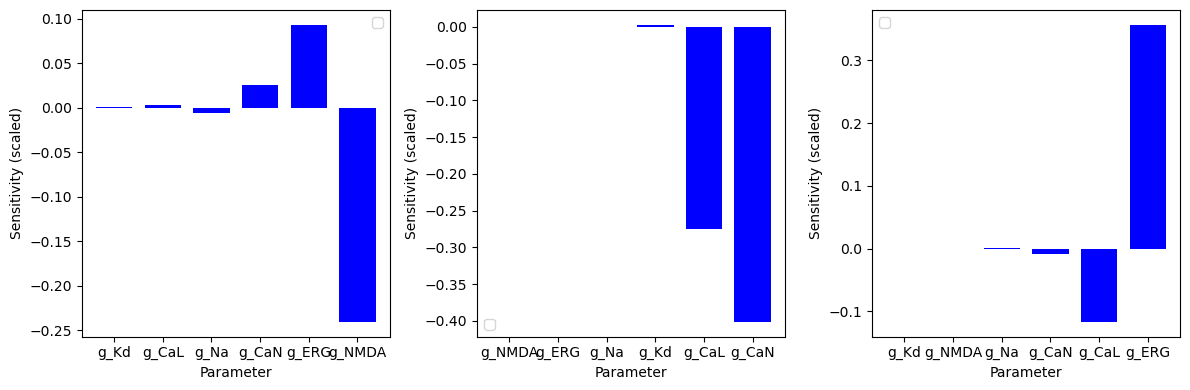

In [32]:
# Sensitivity matrix with scaling factors
from da import sensitivity_matrix

V = -55.5

population = get_individual(f=0, normalize=True)
population = np.array([population])

#scaling_factors = np.array([1e3, 1e4, 1e2, 1e2, 1e4, 1e3, 1e-1]) * 10  # Example scaling factors
scaling_factors = np.array([1, 1, 1, 1, 1, 1])
sens_mat = sensitivity_matrix(V, *(population.T), **get_default_parameters(), normalize=False).squeeze()[:, :-1]

print(sens_mat.shape)

# Get sorted indices for each row
sorted_indices = np.argsort(np.abs(sens_mat))

# Apply scaling factors
sens_mat = sens_mat * scaling_factors  
print(sens_mat.shape, sorted_indices.shape)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
width = 0.25  # Width for split bars
full_width = 0.75  # Width for normal bars
x_labels = ['g_Na', 'g_Kd', 'g_CaL', 'g_CaN', 'g_ERG', 'g_NMDA']
x = np.arange(len(x_labels))  # Base x positions

print(sens_mat.shape)

for i in range(3):
    values = sens_mat[i, sorted_indices[i]]  # Sorted values
    sorted_labels = [x_labels[j] for j in sorted_indices[i]]  # Sorted labels
    
    for j in range(6):  
        ax[i].bar(j, values[j], full_width, color='blue')  # Keep full width for other bars

    ax[i].set_xlabel('Parameter')
    ax[i].set_ylabel('Sensitivity (scaled)')
    ax[i].set_xticks(np.arange(6))
    ax[i].set_xticklabels(sorted_labels)
    ax[i].legend()


plt.tight_layout()
plt.savefig('figures/da_sensitivity_vth_scaled.svg')
plt.show()